## Data input 

Set work directory

In [1]:
setwd('e:/permafrost')
wd_16s <- file.path(getwd(),"data/16S")
# if (!dir.exists(wd_16s)) {
#   dir.create(wd_16s)
# }
wd_fun <- file.path(getwd(),"data/metagenome")
save.dir <- file.path(getwd(),"result")

Loading packages

In [2]:
library(phyloseq)
library(ape)
library(Biostrings)

Warning message:
"package 'ape' was built under R version 4.0.5"
Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.0.5"
Loading required package: parallel


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit,

Read data

In [3]:
## metadata
metadata <- read.delim(file.path(wd_16s, "./metadata_final.txt"), header = T, sep = "\t")
rownames(metadata) <- (metadata$sample_id)
## dna sequences
dna_seqs <- readDNAStringSet(file.path(wd_16s, "./otus.fa"), format = "fasta", nrec = -1L, 
                             skip = 0L, seek.first.rec = FALSE,
                             use.names = TRUE)

## tree
tree <- read_tree(file.path(wd_16s, "./otus.nwk"))
## otu table
otu <- read.delim(file.path(wd_16s, "./otutab.txt"), header = T, row.names = 1, sep = "\t")
otu <- otu[, metadata$sample_id[metadata$sample_id %in% colnames(otu)]]
## rarefy out table
otu_rare <- read.delim(file.path(wd_16s, "./otutab_rare.txt"), header = T, row.names = 1, sep = "\t")
otu_rare <- otu_rare[, metadata$sample_id[metadata$sample_id %in% colnames(otu_rare)]]
## tax
tax <- read.delim(file.path(wd_16s, "./taxonomy.txt"), header = T, row.names = 1, sep = "\t")
tax <- as.matrix(tax)

Construct a phyloseq object

In [5]:
# phyloseq object
otu <- otu_table(otu, taxa_are_rows = TRUE)
otu_rare <- otu_table(otu_rare, taxa_are_rows = TRUE)
tax <- tax_table(tax)
meta_dat <- sample_data(metadata)
phylo <- phyloseq(otu, tax, meta_dat, tree, dna_seqs)
phylo_rare <- phyloseq(otu_rare, tax, meta_dat, tree, dna_seqs)
# phylo_SUR <- subset_samples(phylo, layer == 'SUR') 
# phylo_SUB <- subset_samples(phylo, layer == 'SUB') 
# phylo_PL <- subset_samples(phylo, layer == 'PL') 
phylo

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 12855 taxa and 66 samples ]
sample_data() Sample Data:       [ 66 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 12855 taxa by 7 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 12855 tips and 12853 internal nodes ]
refseq()      DNAStringSet:      [ 12855 reference sequences ]

Read functional table

## Calculate alpha diversity

Load packages

In [7]:
library(microbiome)
library(tidyverse, quietly = TRUE, warn.conflicts = F)

Loading required package: ggplot2


microbiome R package (microbiome.github.com)
    


 Copyright (C) 2011-2021 Leo Lahti, 
    Sudarshan Shetty et al. <microbiome.github.io>



Attaching package: 'microbiome'


The following object is masked from 'package:ggplot2':

    alpha


The following object is masked from 'package:Biostrings':

    coverage


The following objects are masked from 'package:IRanges':

    coverage, transform


The following object is masked from 'package:S4Vectors':

    transform


The following object is masked from 'package:base':

    transform


-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.1.6      v dplyr   1.0.10
v tidyr   1.2.1      v stringr 1.4.1 
v readr   2.1.3      v forcats 0.5.2 
v purrr   0.3.4      
Warning message:
"package 'tibble' was built under R version 4.0.5"
Warning message:
"package 'tidyr' was built under R version 4.2.1"
Warning message:
"package 'purrr' was built under R version 4.0.5"

Determine the alpha diversity with *estimate_richness* function in phyloseq package

In [8]:
library(phyloseq)
alpha_div <- estimate_richness(phylo_rare, measures = c("Observed", "Chao1", 'Shannon', 'Simpson'))
library(picante)
pd <- pd(t(otu), tree, include.root = F) # estimate the phylogenetic diversity
alpha_div <- cbind(Layers = metadata$Layer, alpha_div, Faith = pd$PD,
                   Evenness = alpha_div$Shannon/log(alpha_div$Observed)) %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL')))

Loading required package: vegan

Warning message:
"package 'vegan' was built under R version 4.0.5"
Loading required package: permute

Warning message:
"package 'permute' was built under R version 4.0.5"
Loading required package: lattice

This is vegan 2.6-2


Attaching package: 'vegan'


The following object is masked from 'package:microbiome':

    diversity


Loading required package: nlme


Attaching package: 'nlme'


The following object is masked from 'package:dplyr':

    collapse


The following object is masked from 'package:Biostrings':

    collapse


The following object is masked from 'package:IRanges':

    collapse




Boxplot for evenness


Attaching package: 'ggpubr'


The following object is masked from 'package:ape':

    rotate




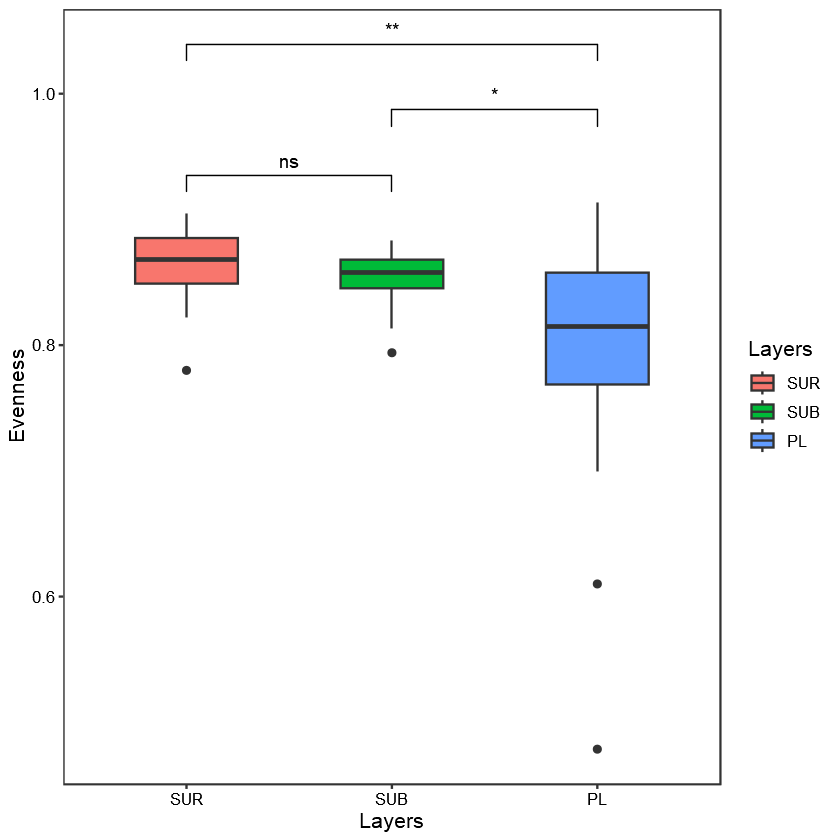

In [9]:
library(ggpubr)
library(ggplot2)
my_comparisons <- list( c("SUR", "SUB"), c("SUB", "PL"), c("SUR", "PL") )
p <- ggplot(alpha_div, aes(x = Layers, y = Evenness)) + 
  geom_boxplot(width = 0.5, aes(fill = Layers))+
  stat_compare_means(comparisons = my_comparisons, paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols)+
  labs(x = 'Layers', y = 'Evenness', fill='Layers') +
  theme_bw() +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        panel.grid = element_blank())
print(p)

Boxplot for Faith

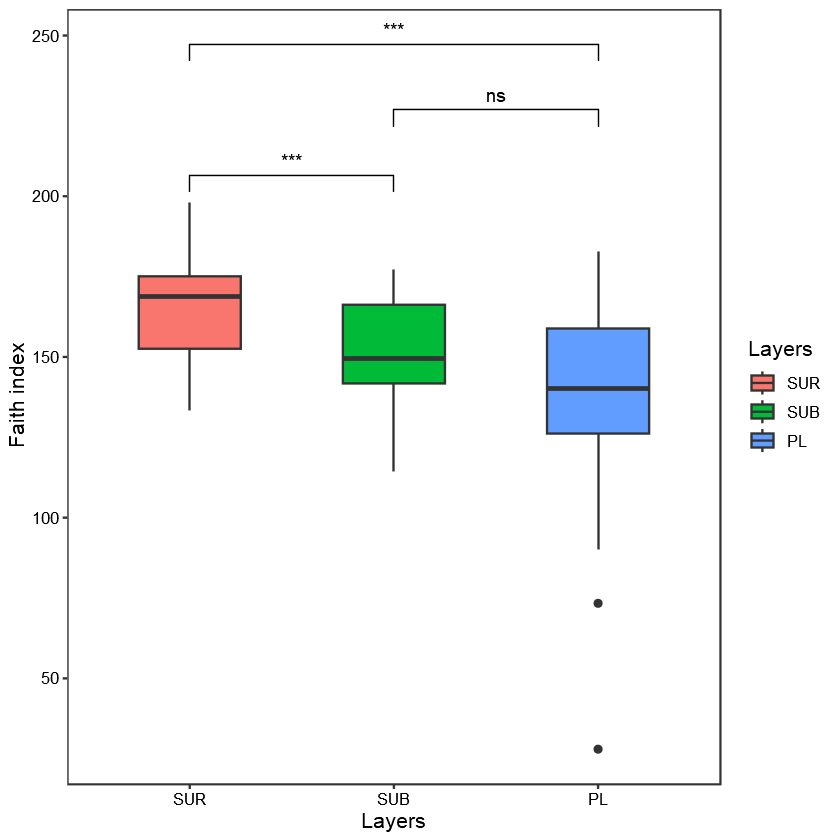

In [10]:
p <- ggplot(alpha_div, aes(x = Layers, y = Faith)) + 
  geom_boxplot(width = 0.5, aes(fill = Layers))+
  stat_compare_means(comparisons = my_comparisons,  paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols)+
  labs(x = 'Layers', y = 'Faith index', fill='Layers') +
  theme_bw() +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        panel.grid = element_blank())
print(p)

## Analysis for beta diversity

Load packages

In [11]:
library(vegan)
library(pairwiseAdonis)

Loading required package: cluster



PERMANOVA test

In [13]:
tax_dist <- as.matrix(vegdist(t(otu), "bray" ))
adonis2(tax_dist ~ Layer, data = metadata)

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer,2,3.151202,0.1616654,6.074494,0.001
Residual,63,16.340926,0.8383346,NA,NA
Total,65,19.492128,1.0000000,NA,NA


In [15]:
set.seed(123)
pairwise.adonis(tax_dist, metadata$Layer) #pairwise adonis test

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SUR vs SUB,1,0.05123811,20.677801,0.3299063,0.001,0.003,*
SUR vs PL,1,0.06346050,23.807563,0.3617755,0.001,0.003,*
SUB vs PL,1,0.01481828,4.780933,0.1021983,0.006,0.018,.


PCoA plot with bray-curties as distance

[1] 16.3  9.4

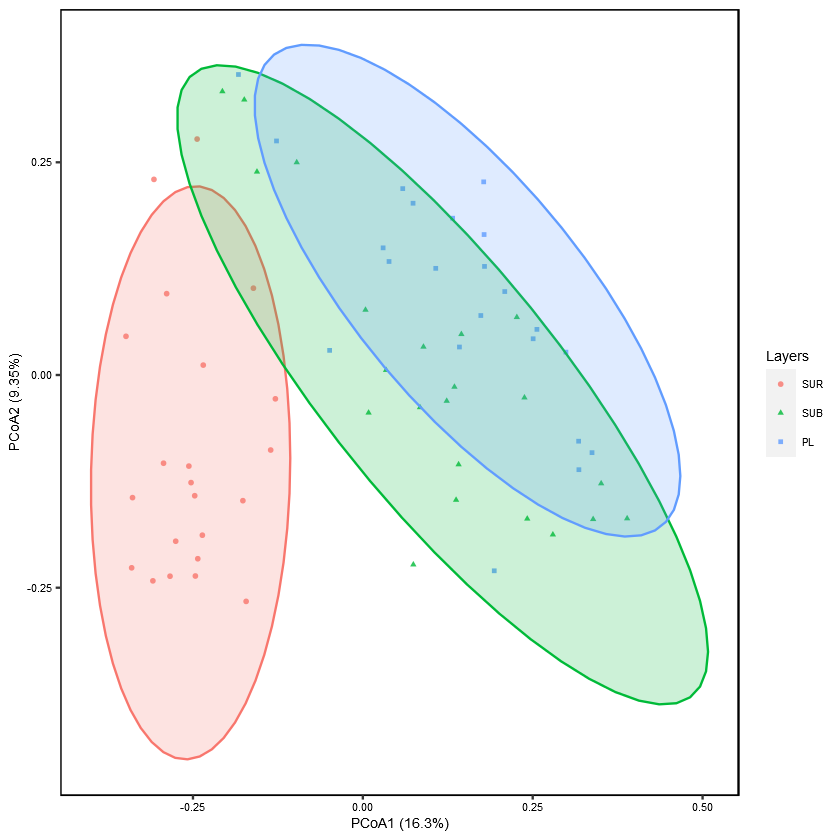

In [16]:
ord.tax <-  cmdscale(tax_dist,  k = 2, eig = T, add = T)
round(ord.tax$eig*100/sum(ord.tax$eig),1)[c(1,2)]
pcoa_tax_plot <- data.frame(Layers = metadata$Layer, scores(ord.tax)) %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Dim1, y = Dim2, shape = Layers, color = Layers)) + 
  geom_point(size = 1, alpha = 0.8) + 
  stat_ellipse(geom = "polygon", aes(fill = Layers), alpha = 0.2, show.legend = FALSE, level = 0.95) +
  labs(x=paste("PCoA1 (", format(100 * ord.tax$eig[1] / sum(ord.tax$eig), digits = 3), "%)", sep = ""),
       y=paste("PCoA2 (", format(100 * ord.tax$eig[2] / sum(ord.tax$eig), digits = 3), "%)", sep = "")) +
  theme(axis.title = element_text(size = 8, colour = "black"),
        axis.text = element_text(size = 6, colour = "black"),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 6),
        panel.grid = element_blank(),
        panel.background = element_blank(), 
        panel.border = element_rect(fill = NA, colour = "black"))
print(pcoa_tax_plot)
# ggsave(file.path(save.dir, "./figs/beta/PCoA_tax_bray.pdf"),
#        pcoa_tax_plot, width = 89, height = 59, units = "mm")

Difference in taxonomic variance among layers

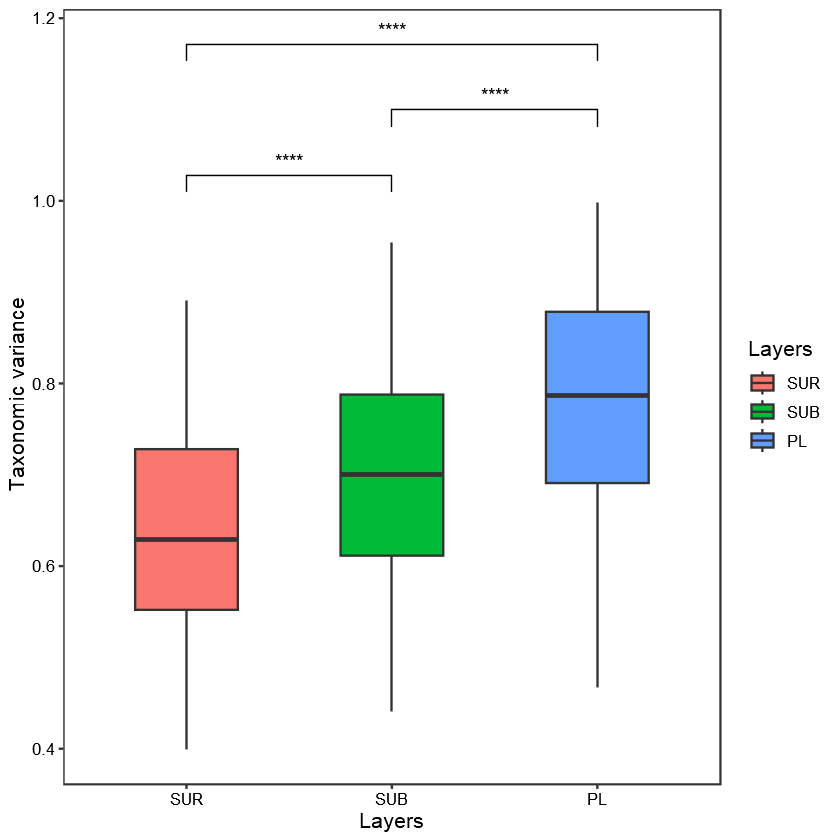

In [17]:
beta_tax_plot <- sapply(unique(metadata$Layer), function(x) usedist::dist_subset(tax_dist, grep(x, metadata$sample_id, value = T))) %>%
  data.frame() %>% gather("Layers", "distance") %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Layers, y = distance)) + 
  geom_boxplot(width = 0.5, aes(fill = Layers))+
  stat_compare_means(comparisons = my_comparisons,  paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols)+
  labs(x = 'Layers', y = 'Taxonomic variance', fill='Layers') +
  theme_bw() +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        panel.grid = element_blank())
print(beta_tax_plot)
# ggsave(file.path(save.dir, "./figs/beta/tax_variance.pdf"),
#        beta_tax_plot, width = 89, height = 89, units = "mm")


## phylogeny

In [18]:
### PERMANOVA test
phy_dist <- as.matrix(UniFrac(phylo, weighted = TRUE, normalized = TRUE, parallel = T, fast = TRUE))
adonis2(phy_dist ~ Layer, data = metadata)

Warning message in UniFrac(phylo, weighted = TRUE, normalized = TRUE, parallel = T, :
"Randomly assigning root as -- ASV_3385 -- in the phylogenetic tree in the data you provided."
Warning message:
"executing %dopar% sequentially: no parallel backend registered"


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Layer,2,0.1604727,0.1784466,6.842001,0.001
Residual,63,0.7388029,0.8215534,NA,NA
Total,65,0.8992756,1.0000000,NA,NA


In [19]:
set.seed(123)
pairwise.adonis(phy_dist, metadata$Layer)

pairs,Df,SumsOfSqs,F.Model,R2,p.value,p.adjusted,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SUR vs SUB,1,0.09447149,15.132845,0.26487120,0.001,0.003,*
SUR vs PL,1,0.15648506,17.039428,0.28861099,0.001,0.003,*
SUB vs PL,1,0.05193351,4.619926,0.09909767,0.018,0.054,


Warning message in UniFrac(physeq, ...):
"Randomly assigning root as -- ASV_3385 -- in the phylogenetic tree in the data you provided."
Warning message in plot_ordination(phylo, ord.phy, color = "layer"):
"Color variable was not found in the available data you provided.No color mapped."


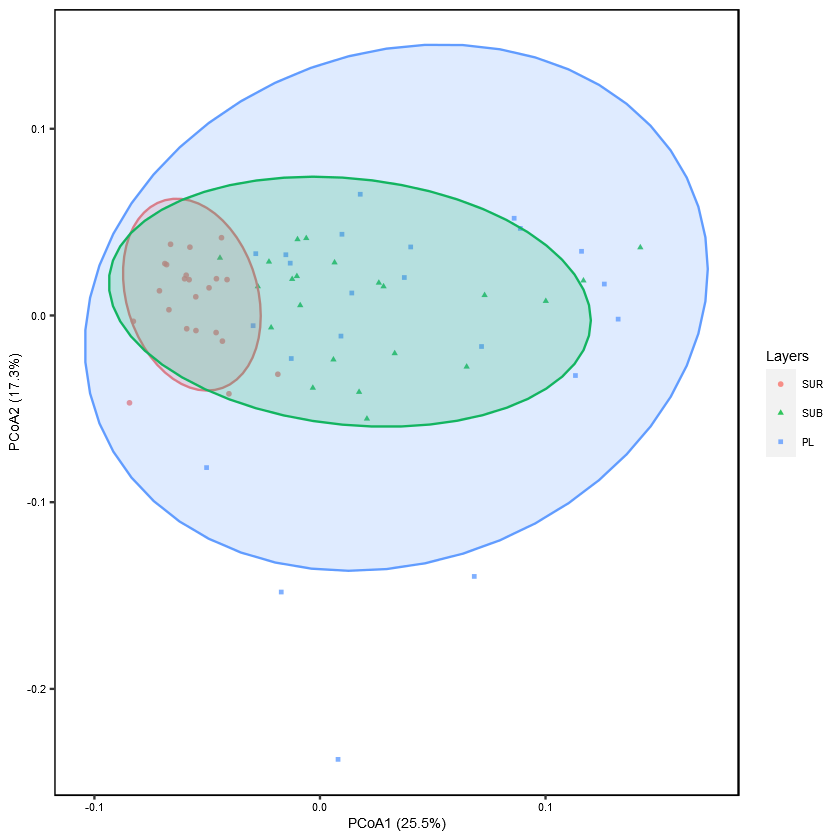

In [20]:
### PCoA plot with unweighted UniFrac as distance
ord.phy <- ordinate(phylo, method = "PCoA", distance = "unifrac", weighted = TRUE)
PCoA_phy_plot <- plot_ordination(phylo, ord.phy, color = "layer") + theme(aspect.ratio = 1)
PCoA_unifrac_plot <- data.frame(Layers = metadata$Layer, ord.phy$vectors[, 1:2]) %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Axis.1, y = Axis.2, shape = Layers, color = Layers)) + 
  geom_point(size = 1, alpha = 0.8) + 
  stat_ellipse(geom = "polygon", aes(fill = Layers), alpha = 0.2, show.legend = FALSE, level = 0.95) +
  labs(x=paste("PCoA1 (", format(100 * ord.phy$values[1, 2], digits = 3), "%)", sep = ""),
       y=paste("PCoA2 (", format(100 * ord.phy$values[2, 2], digits = 3), "%)", sep = "")) +
  theme(axis.title = element_text(size = 8, colour = "black"),
        axis.text = element_text(size = 6, colour = "black"),
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 6),
        panel.grid = element_blank(),
        panel.background = element_blank(), 
        panel.border = element_rect(fill = NA, colour = "black"))
print(PCoA_unifrac_plot)
# ggsave(file.path(save.dir, "./figs/beta/PCoA_unifrac_plot.pdf"),
#        PCoA_unifrac_plot, width = 89, height = 59, units = "mm")

### determine the betaMNTD

In [ ]:
#### Method 1
require(picante)
beta.mntd.weighted <- as.matrix(comdistnt(t(data.frame(otu)), cophenetic(tree), abundance.weighted = T))

#### Method 2 (time efficiency)
# library(doParallel)  
# cores <- detectCores() - 2  

# p.dist.mat <- cophenetic(tree)
# get.presents <- function(x) {
#   names(x[x > 0])
# }
# list.of.names <- apply(otu, 2, get.presents)
# Dnn.apply.funtion <- function(x) {
#   tmp.function <- function(z) {
#     mean(c(apply(p.dist.mat[x, z], MARGIN = 1, min, na.rm = T), 
#          apply(p.dist.mat[x, z], MARGIN = 2, min, na.rm = T)))
#   }
#   lapply(list.of.names, FUN = tmp.function)
# }
# beta.mntd.weighted <- do.call(cbind, lapply(list.of.names, Dnn.apply.funtion))

# beta.mntd.weighted <- read.table(file.path(save.dir, './tables/beta.mntd.weighted.txt'),
#                                  header = T, row.names = 1)
### difference in MNTD among layers
beta_MNTD_plot <- sapply(unique(metadata$Layer), function(x) usedist::dist_subset(beta.mntd.weighted, grep(x, metadata$sample_id, value = T))) %>%
  data.frame() %>% gather("Layers", "distance") %>%
  mutate(Layers = factor(Layers, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = Layers, y = distance)) + 
  geom_boxplot(width = 0.5, aes(fill = Layers))+
  stat_compare_means(comparisons = my_comparisons,  paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols)+
  labs(x = 'Layers', y = 'beta-MNTD', fill='Layers') +
  theme_bw() +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 12),
        legend.text = element_text(size = 10),
        panel.grid = element_blank())
print(p.dist.mat)
# ggsave(file.path(save.dir, "./figs/beta/beta_mntd.pdf"),
#        beta_MNTD_plot, width = 89, height = 89, units = "mm")


## Composition

### Determine the compositions within top 10 phylums

In [21]:
subphylo <- tax_glom(phylo, 'Phylum')
subphylo.rel  = transform_sample_counts(subphylo, function(x) x / sum(x) )
ntaxa(subphylo.rel)
ra.tab <- otu_table(subphylo.rel)
sum(ra.tab[, 1])
subtaxa_tab <- tax_table(subphylo.rel)[, 2]

[1] 59

[1] 1

### Boxplot shows the community composition

Warning message in stat_compare_means(aes(group = layer), paired = TRUE, p.adjust.method = "BH", :
"Ignoring unknown parameters: `p.adjust.method`"
Warning message:
"The dot-dot notation (`..p.signif..`) was deprecated in ggplot2 3.4.0.
i Please use `after_stat(p.signif)` instead."


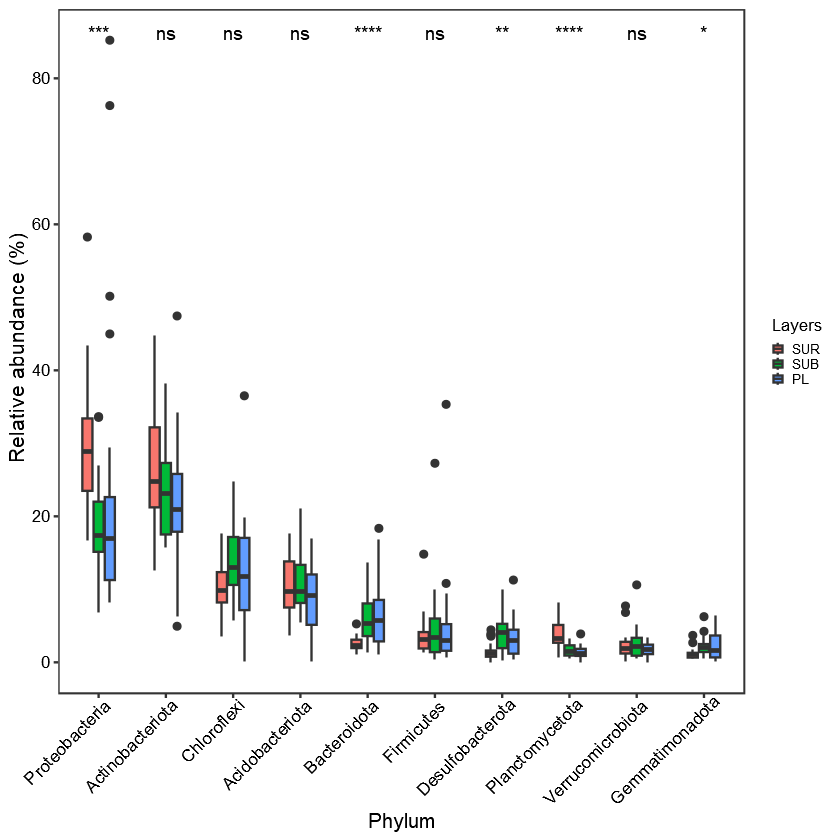

In [22]:
box_plot <- data.frame(subtaxa_tab, ra.tab) %>% group_by(Phylum) %>% 
  summarise(across(everything(), sum)) %>% 
  mutate(MRA = rowMeans(select(., colnames(ra.tab)))) %>%
  arrange(desc(MRA)) %>% dplyr::top_n(10, MRA) %>%
  select(., -c('MRA')) %>% 
  mutate(Phylum = factor(Phylum, levels = Phylum)) %>%
  tidyr::pivot_longer(cols = -c(Phylum), names_to = "sample_id", values_to = 'rel_abun') %>%
  mutate(layer = sapply(stringr::str_split(sample_id, "_",  n = 2), `[`, 1)) %>%
  mutate(layer = factor(layer, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(Phylum, rel_abun*100)) + 
  geom_boxplot(width = 0.5, aes(fill = layer)) +
  stat_compare_means(aes(group = layer),  paired = TRUE, 
                     p.adjust.method = "BH", label = "p.signif") +
  #scale_fill_manual(values= cols) +
  labs(x = 'Phylum', y = 'Relative abundance (%)', fill='Layers') +
  theme_bw() +
  guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.5)) +
  theme(axis.title = element_text(size = 12, colour = "black"),
        axis.text.x = element_text(size = 10, colour = "black", 
                                   angle = 45, vjust = 1, hjust = 1),
        axis.text.y = element_text(size = 10, colour = "black"),
        legend.title = element_text(size = 10),
        legend.text = element_text(size = 8),
        panel.grid = element_blank())
print(box_plot)

In [ ]:
### Barplot shows the community composition

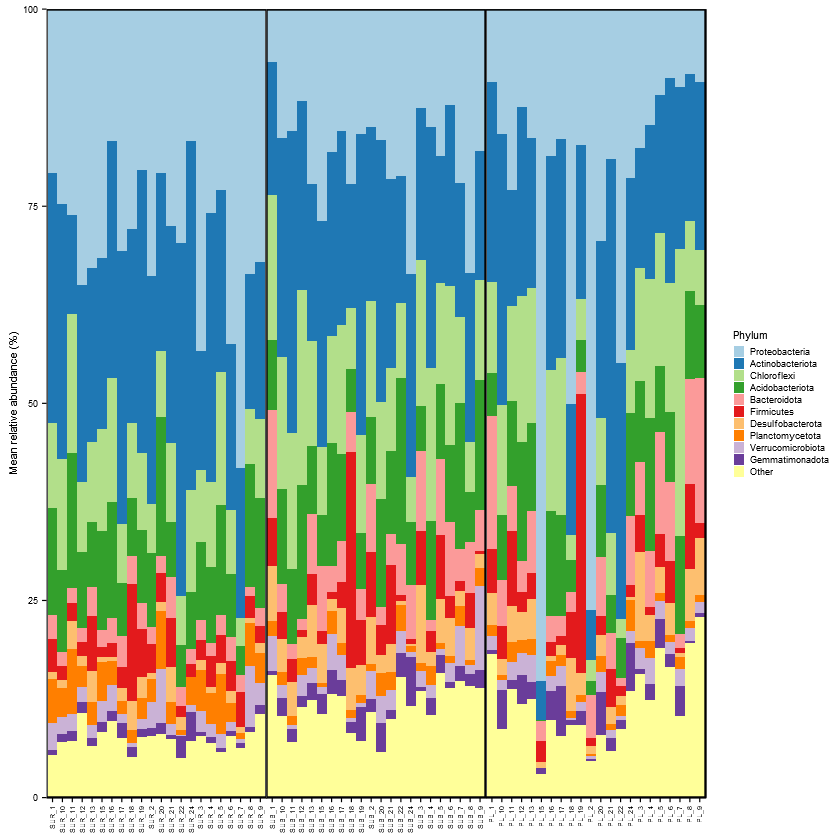

In [23]:
bar_plot <- data.frame(subtaxa_tab, ra.tab) %>% 
  mutate(MRA = rowMeans(select(., colnames(ra.tab)))) %>%
  arrange(desc(MRA)) %>% dplyr::top_n(10, MRA) %>%
  select(., -c('MRA')) %>% 
  bind_rows(summarise_all(., ~if(is.numeric(.)) 1-sum(.) else "Other")) %>%
  mutate(Phylum = factor(Phylum, levels = Phylum)) %>%
  pivot_longer(cols = -c(Phylum), names_to = "sample_id", values_to = 'rel_abun') %>%
  mutate(layer = sapply(stringr::str_split(sample_id, "_",  n = 2), `[`, 1)) %>%
  mutate(layer = factor(layer, levels = c('SUR', 'SUB', 'PL'))) %>%
  ggplot(aes(x = sample_id, y = 100*rel_abun, fill = Phylum))+
  geom_bar(stat = "identity") +
  scale_fill_brewer(palette = "Paired")+
  scale_y_continuous(expand = c(0,0))+
  labs(x = 'Sample', y = 'Mean relative abundance (%)') +
  theme_linedraw() + 
  guides(fill = guide_legend(keywidth = 0.5, keyheight = 0.5)) +
  facet_grid(~layer, scales = "free_x", space = "free_x") + 
  theme(axis.title.x = element_blank(), 
        axis.title.y = element_text(size = 6, colour = "black"),
        panel.grid.minor = element_blank(), 
        panel.grid.major = element_blank(), 
        axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, size = 4), 
        axis.text.y = element_text(size = 5), 
        panel.spacing = unit(0, "lines"),
        strip.text = element_blank(),
        strip.background = element_blank(),
        legend.title = element_text(size = 6), 
        legend.text = element_text(size = 5))
print(bar_plot)
# ggsave(file.path(save.dir, "./figs/composition/tax_composition_10.pdf"), box_plot, width = 189, height = 95, units = "mm")  
# ggsave(file.path(save.dir, "./figs/composition/tax_composition_bar.pdf"), bar_plot, width = 120, height = 65, units = "mm")  

## Unique otus profile among three layers

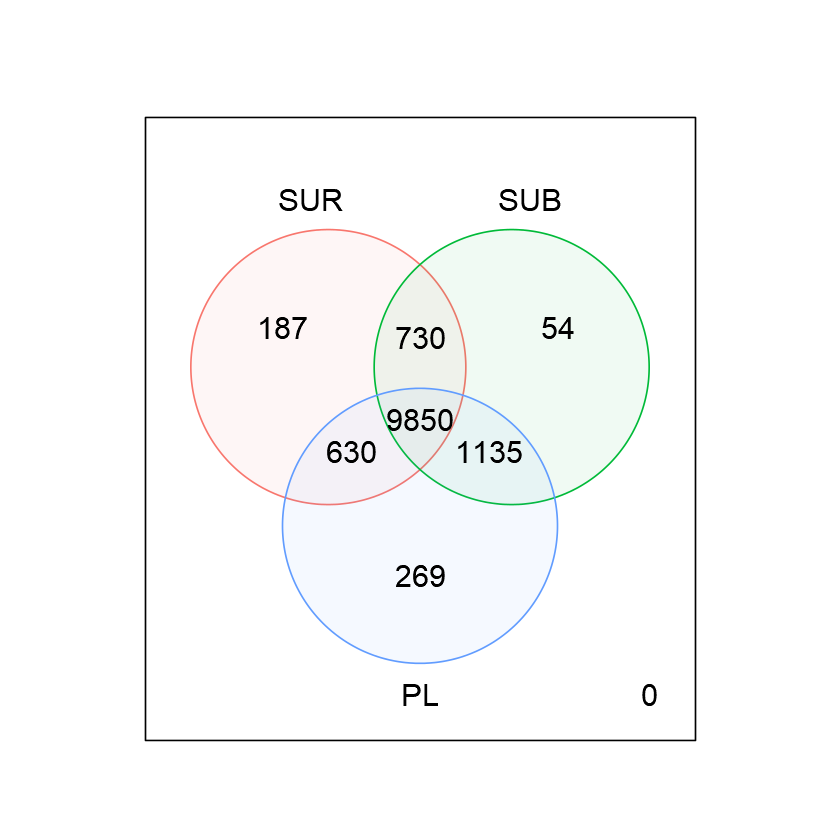

In [26]:
# Load the library
library(limma)

# Generate example data
sur_venn <- otu %>% data.frame() %>%
  mutate(rowsum = rowSums(select(., grep('SUR', metadata$sample_id, value = T)))) %>%
  filter(rowsum > 0) %>%
  rownames()
sub_venn <- otu %>% data.frame() %>%
  mutate(rowsum = rowSums(select(., grep('SUB', metadata$sample_id, value = T)))) %>%
  filter(rowsum > 0) %>%
  rownames()
pl_venn <- otu %>% data.frame() %>%
  mutate(rowsum = rowSums(select(., grep('PL', metadata$sample_id, value = T)))) %>%
  filter(rowsum > 0) %>%
  rownames()

# What are the possible letters in the universe?
universe <- sort(unique(c(sur_venn, sub_venn, pl_venn)))

# Generate a matrix, with the sets in columns and possible letters on rows
Counts <- matrix(0, nrow=length(universe), ncol=3)
# Populate the said matrix
for (i in 1:length(universe)) {
  Counts[i,1] <- universe[i] %in% sur_venn
  Counts[i,2] <- universe[i] %in% sub_venn
  Counts[i,3] <- universe[i] %in% pl_venn
}

# Specify the colors for the sets
gg_color_hue <- function(n) {
  hues = seq(15, 375, length = n + 1)
  hcl(h = hues, l = 65, c = 100)[1:n]
}
n = 3 #Prepare a palette of 3 colors:
cols = gg_color_hue(n)

# Name the columns with the sample names
colnames(Counts) <- c("SUR","SUB","PL")
vennDiagram(vennCounts(Counts), circle.col = cols)


### Using VennDiagram package

ERROR: Error in venn.diagram(filename = NULL, cex = 1, cat.cex = 1, lwd = 2, : argument "x" is missing, with no default


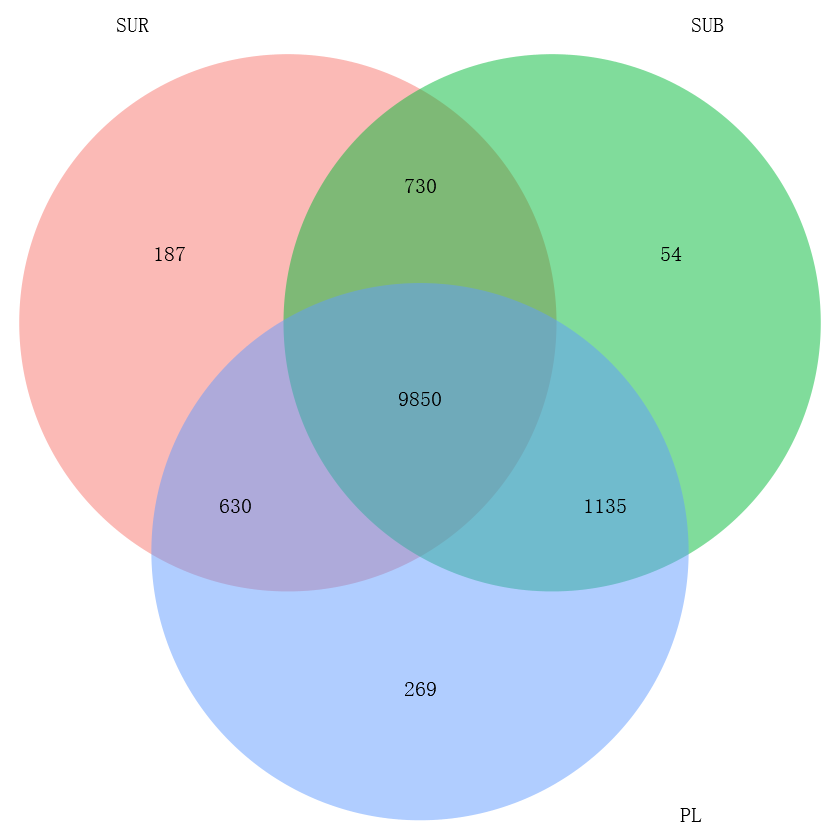

In [27]:
# library
library(VennDiagram)

#Make the plot
venn_plot <- venn.diagram(
  x = list(
    otu %>% data.frame() %>%
      mutate(rowsum = rowSums(select(., grep('SUR', metadata$sample_id, value = T)))) %>%
      filter(rowsum > 0) %>%
      rownames(), 
    otu %>% data.frame() %>%
      mutate(rowsum = rowSums(select(., grep('SUB', metadata$sample_id, value = T)))) %>%
      filter(rowsum > 0) %>%
      rownames(), 
    otu %>% data.frame() %>%
      mutate(rowsum = rowSums(select(., grep('PL', metadata$sample_id, value = T)))) %>%
      filter(rowsum > 0) %>%
      rownames()
  ),
  category.names = c("SUR" , "SUB" , "PL"),
  filename = NULL,
  # output = F,
  # imagetype="png" ,
  # height = 480 ,
  # width = 480 ,
  # resolution = 300,
  # compression = "lzw",
  # Circles
  lwd = 2,
  lty = 'blank',
  fill = cols,
  # Numbers
  cex = 1,
  fontfamily = "sans",
  # Set names
  cat.cex = 1,
  cat.default.pos = "outer",
  cat.pos = c(-27, 27, 135),
  cat.dist = c(0.055, 0.055, 0.085),
  cat.fontfamily = "sans",
  cat.col = 'black',
  rotation = 1
)
grid::grid.draw(venn_plot)
# grid.newpage()
# pdf(file= file.path(save.dir, "OTU_Group_venn.pdf"), height = 3, width = 3)
# grid.draw(venn_plot)
# dev.off()

plt <- venn.diagram(
  filename = NULL,
  cex = 1,
  cat.cex = 1,
  lwd = 2,
)
